# Анализ оттока клиентов в сети фитнес-центров «Культурист-датасаентист»

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.
<br>Распространённая проблема фитнес-клубов — отток клиентов. Клиенты могут уходить демонстративно: закрывают договор или просят удалить аккаунт. Однако чаще клиенты перестают пользоваться сервисом тихо.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей.

<br><b>Цель</b> — провести анализ и подготовить план действий по удержанию клиентов.

<br><b>Задачи:</b>
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

## Оглавление


[1. Импорт и предобработка данных](#1)
<br>[2. Исследовательский анализ данных (EDA)](#2)
<br>[3. Построение модели прогнозирования оттока клиентов](#3)
<br>[4. Кластеризация клиентов](#4)
<br>[5. Выводы и рекомендации](#5)

## 1. Импорт и предобработка данных <a class="anchor" id="1"></a>

In [2]:
#импортируем необходимые библиотеки
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#импорт библиотек для работы с предсказанием и кластеризацией данных
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
df = pd.read_csv('gym_churn.csv')

In [4]:
#посмотрим на данные
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

#### Данные загружены корректно, пропуcков нет
- В датасете данные по 4 000 клиентов

In [6]:
#проверим на наличие полных дубликатов
df.duplicated().sum()

0

#### Полных дубликатов нет

## 2. Исследовательский анализ данных (EDA) <a class="anchor" id="2"></a>

In [8]:
#посмотрим на характеристики всех признаков
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


#### Характеристики признаков
- Примерно одинаковое кол-во мужчин и женщин в датасете (gender mean = 0.51)
- 85% живут недалеко от фитнес-центра
- Почти половина клиентов(49%) имеют партнерскую компанию и 31% пришли по промо от друзей
- 10% клиентов не предоставило номер телефона. Жаль, так как можно попробовать удержать клиентов, если отправлять им промо, когда снижается активность и снизить отток
- Не менее половины клиентов имеют абонемент на 1 мес. Наврядли это новички, которые пришли попробовать, так как Lifetime по медиане 3. Значит эти клиенты не уверены в своих силах, либо ценовая политика абонементов на 1 мес и например, на 3 не очень отличается
- 41% были на групповых занятиях. Что для меня открытие. Думал, мало кто туда ходит)
- Средний возраст 26-32  года (29 плюс-минус 3), самый возрастной поселитель - 41 год
- В среднем клиент тратит поряд 147 единиц на доп.услуги и товары клуба
- Большинство клиентов в клубе всего 3 месяца. В основном приходят "подкачаться" к сезону? Или что-то не устраивает в клубе?!
- Посещают клуб менее 2х раз в неделю
- Отток 27%. Значительная часть

In [7]:
#посмотрим на средние показатели клиентов, которые ушли из клуба и которые остались
df.groupby('Churn').agg({'mean','median'})

gender           Near_Location           Partner            \
      median      mean        median      mean  median      mean   
Churn                                                              
0          1  0.510037             1  0.873086       1  0.534195   
1          1  0.510839             1  0.768143       0  0.355325   

      Promo_friends            Phone           Contract_period            \
             median      mean median      mean          median      mean   
Churn                                                                      
0                 0  0.353522      1  0.903709               6  5.747193   
1                 0  0.183789      1  0.902922               1  1.728558   

      Group_visits              Age            Avg_additional_charges_total  \
            median      mean median       mean                       median   
Churn                                                                         
0                0  0.464103     30  29.976523                   149.881171   
1                0  0.268615     27  26.989632                   103.814686   

                  Month_to_end_contract           Lifetime            \
             mean                median      mean   median      mean   
Churn                                                                  
0      158.445715                   6.0  5.283089        4  4.711807   
1      115.082899                   1.0  1.662582        1  0.990575   

      Avg_class_frequency_total           Avg_class_frequency_current_month  \
                         median      mean                            median   
Churn                                                                         
0                      2.043252  2.024876                          2.046697   
1                      1.491187  1.474995                          0.979445   

                 
           mean  
Churn            
0      2.027882  
1      1.044546

#### На отток практически не влияет пол и наличие телефона 
- По 2м группам эти показатели примерно одинаковые
- Клиенты реже уходят, если они пришли по рекомендациям друзей и по партнерской программе. Скорее всего эти клиенты ходят в зал вместе с друзьями или коллегами, что меньше дает повода "забить" на занятия. То есть важна социальная составляющая. Это также подтверждает тот факт, что 46% этих клиентов посещают и групповые занятия ('Group_visits')
- Оттоку и постоянству подвержены более молодые клиенты. Их средний возраст 27 лет, в отличие более стабильных. У них. средний возраст 30 лет
- Также влияет удаленность фитнес-клуба от дома. Чем дальше клуб, тем больше нужно сил, чтобы до него добраться
- Маркером, что клиент скоро "отвалится", можно считать среднее кол-во посещений зала. Если клиент начал ходить меньше 1,5 раз в неделю, то скоро он уйдет совсем. Те кто ходят 2 раза в неделю, остаются дольше клиентом клуба
- Уходят в основном те, у кого до конца абонемента остается 1,6 месяцев и менее ('Month_to_end_contract')

'gender'

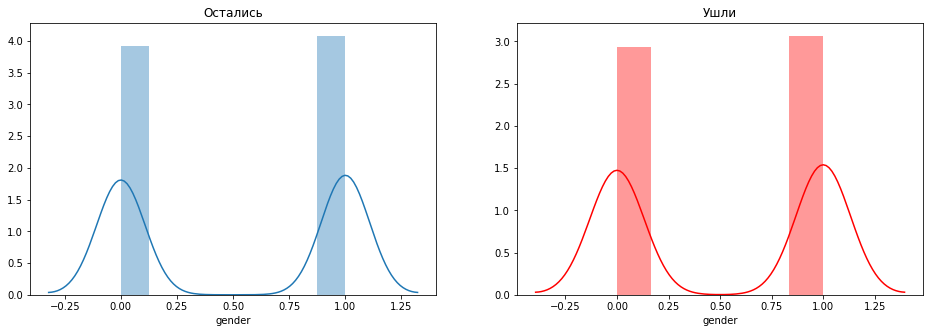

'Near_Location'

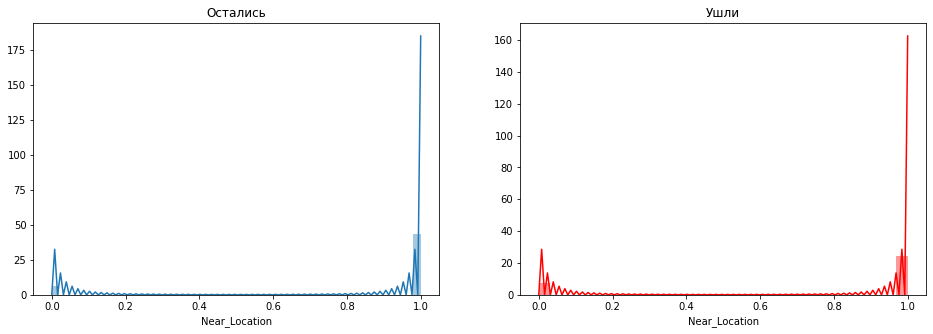

'Partner'

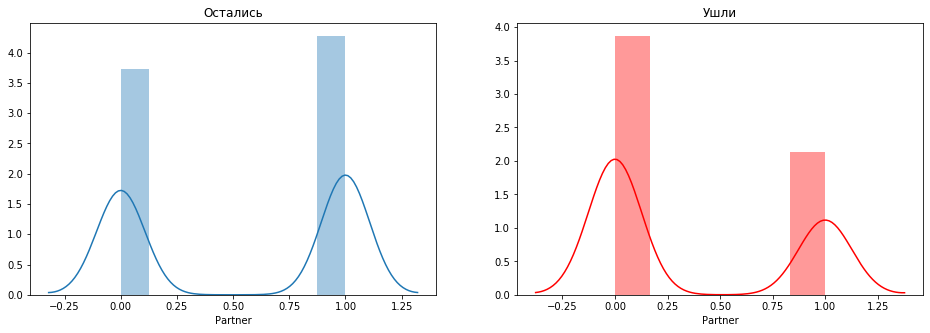

'Promo_friends'

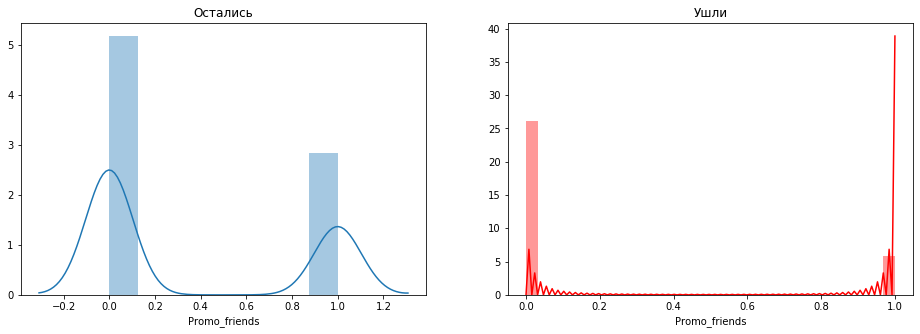

'Phone'

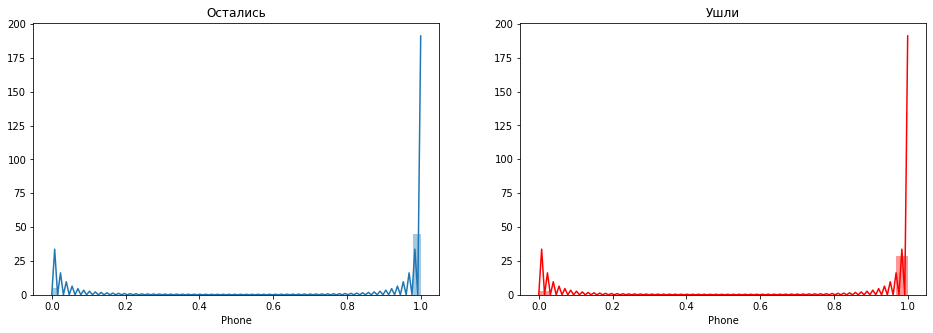

'Contract_period'

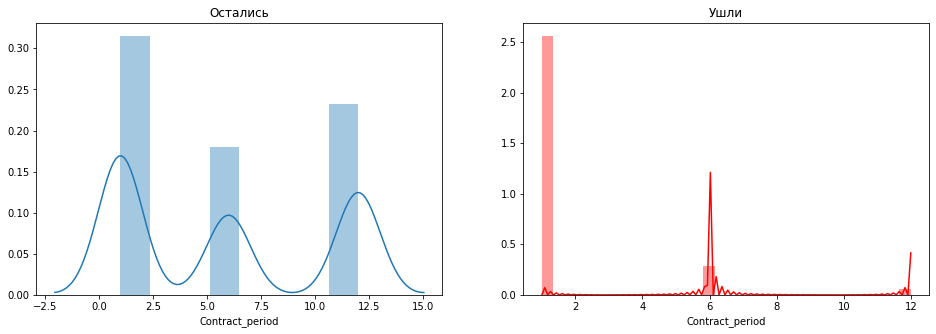

'Group_visits'

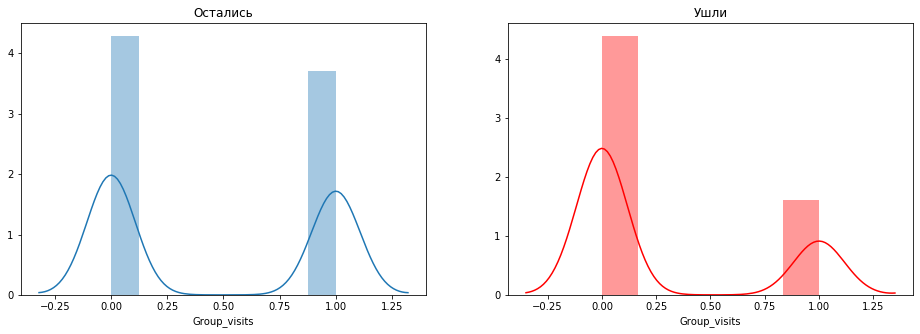

'Age'

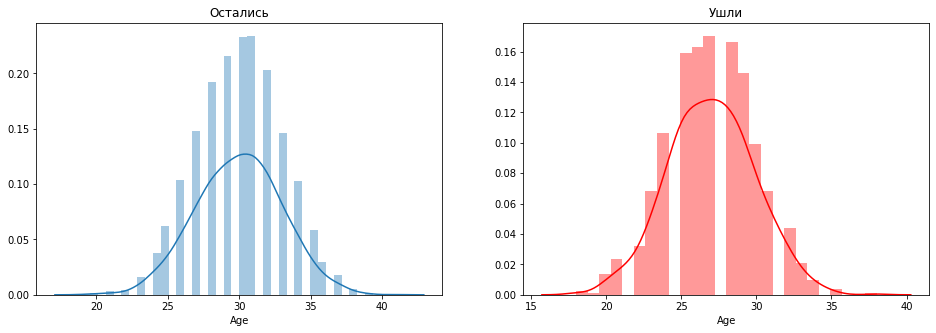

'Avg_additional_charges_total'

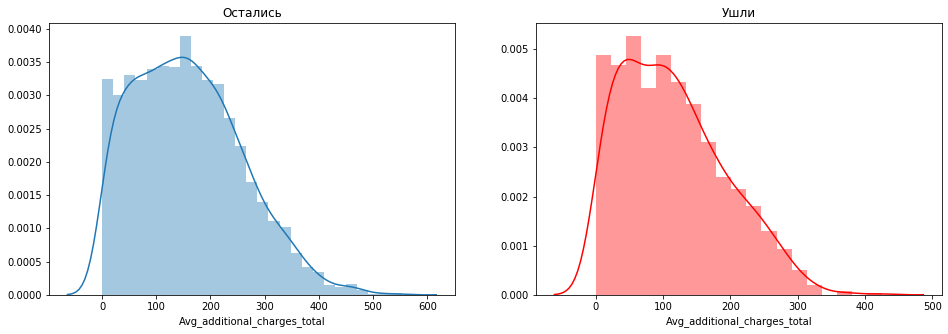

'Month_to_end_contract'

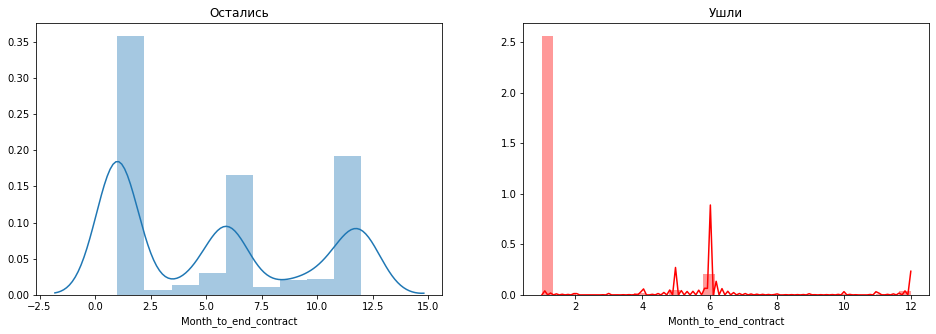

'Lifetime'

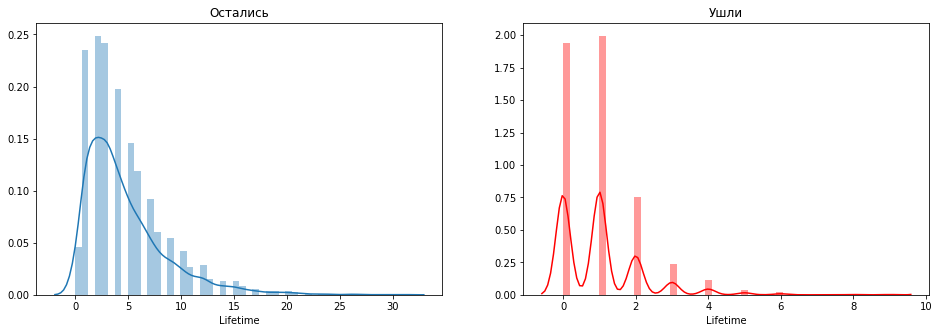

'Avg_class_frequency_total'

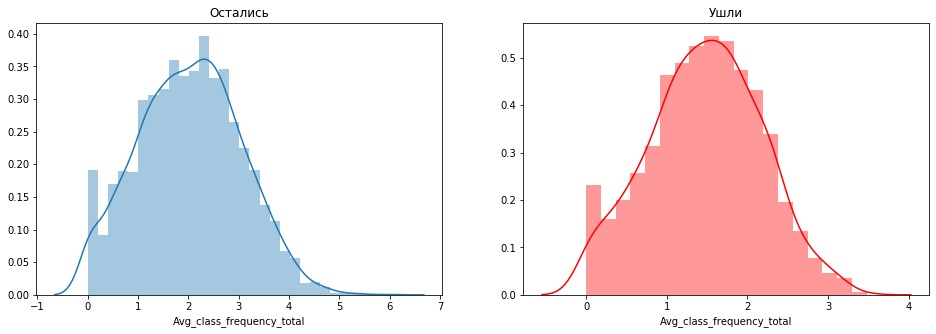

'Avg_class_frequency_current_month'

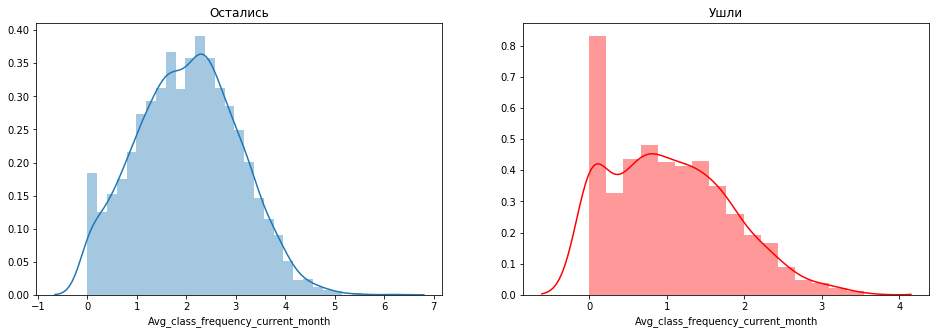

'Churn'

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


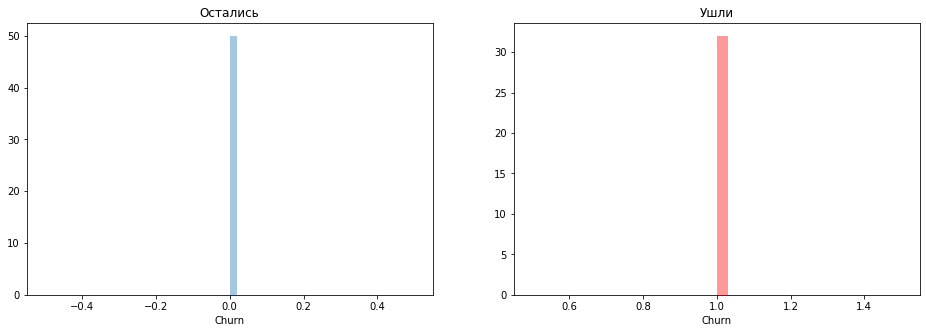

In [8]:
#построим гистограммы по всем признакам для оставшихся и ушедших клиентов
for col in df.columns:
    display(col)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
    sns.distplot(df.query('Churn == 0')[col], ax=ax1)
    ax1.set_title('Остались')
    
    sns.distplot(df.query('Churn == 1')[col], color='red', ax=ax2)
    ax2.set_title('Ушли')
    
    plt.show()

#### Ранее сделанные выводы подтверждаются и на диаграммах
- К ним можно добавить, что в последнем месяце перед уходом из клуба клиенты перестают туда ходить. 'Avg_class_frequency_current_month' у большого кол-ва таких пользователей менее 0.25.
Но нужно начинать "бить тревогу", если этот показатель стал меньше 1

Text(0.5, 1, 'Корреляция признаков')

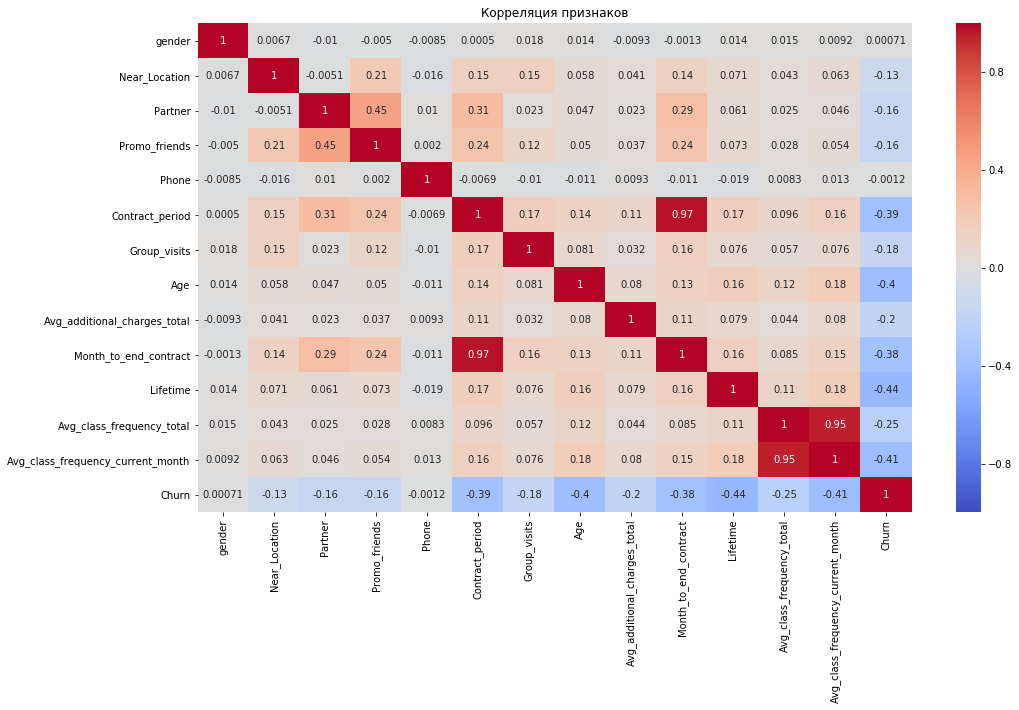

In [9]:
#рассчитаем коррекляцию всех признаков между собой
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.title('Корреляция признаков')

#### Пол и наличие телефона не влияет на отток пользоватей
- Есть очень слабая обратная корреляция оттока в зависимости от возраста, периода посещения клуба ('Lifetime') и среднего кол-во посещений за последний месяц перед уходом ('Avg_class_frequency_current_month')
- Сильная прямая зависимость между:
<br>а) сроком абонемента и кол-во месяцев до окончания этого абонемента ('Contract_period' - 'Month_to_end_contract'),
<br>b) средним кол-вом посещений за все время и средним кол-вом посещений за последний месяц ('Avg_class_frequency_total' - 'Avg_class_frequency_current_month')
<br> Это связано с тем, что чем больше контракт, тем выше вероятность, что останется больше месяцев до конца. Также получается, что характер посещений одинаковый - если клиенты начали ходить редко, то и продолжают ходить редко

# 3. Построение модели прогнозирования оттока клиентов <a class="anchor" id="3"></a>

In [10]:
#выделим из датасета отдельно признаки и целевую переменную
X = df.drop('Churn', axis=1)
y = df['Churn']

#разобъем датасет на обучающую и валидационную выборки в соотношении 80 на 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [11]:
#создадим функцию, которая на вход принимает список моделей, а возвращает метрики
def class_model(model):
    
    for m in model:
        
        display(m)
        #зададим алгоритм модели и обучим ее (LogisticRegression)
        m.fit(X_train, y_train)

        #сделаем прогноз по обученной модели
        y_pred = m.predict(X_test)
        
        display('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
        display('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
        display('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))

In [12]:
#посмотрим на метрики для различных моделей классификации
class_model([LogisticRegression(solver = 'liblinear', random_state = 0),
            RandomForestClassifier(n_estimators = 100, random_state = 0)])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

'Accuracy: 0.93'

'Precision: 0.86'

'Recall: 0.83'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

'Accuracy: 0.92'

'Precision: 0.84'

'Recall: 0.82'

#### Доля правильных ответов, точность и полнота выше у логистической регрессии, по сравнению с алгоритном "случайный лес"
- Для предсказания будем использовать логистическую регрессию

# 4. Кластеризация клиентов <a class="anchor" id="4">

In [13]:
#стандартизируем данные 
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

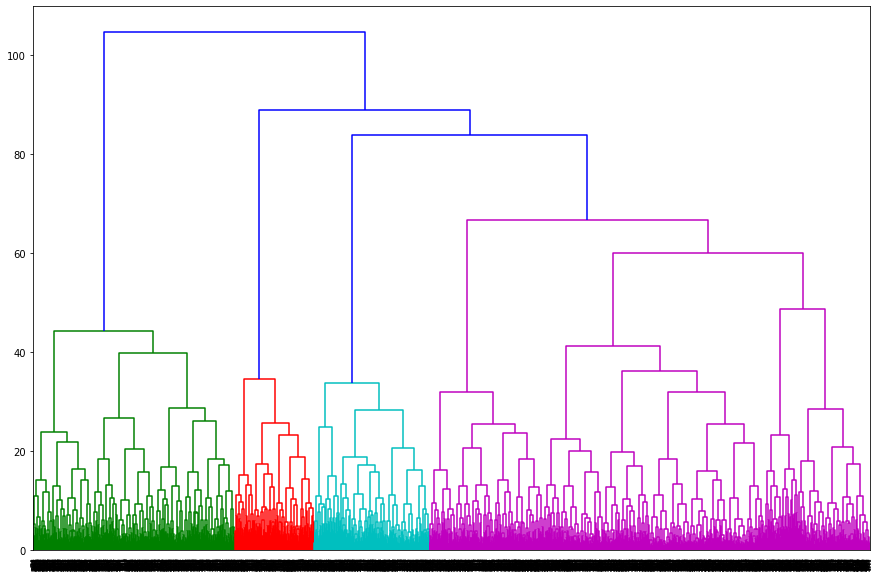

In [14]:
linked = linkage(X_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

#### На основании дендограммы можно выделить 4 кластера
- По 4м цветам. Так как 4ой кластер получается большим по объему, то можно спуститься на уровень ниже и разбить на 5 кластеров

In [15]:
#определим алгоритм модели, применим его к данным и разобьем на кластеры
km = KMeans(n_clusters = 5, random_state=42)
labels = km.fit_predict(X_st)

#добавим номер кластера к первоначальному датасету
df['claster'] = labels

In [16]:
df.groupby('claster').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
claster,,,,,,,,,,,,,,
0,0.502370,0.949447,0.829384,0.998420,1.0,3.097946,0.448657,29.104265,141.774331,2.887836,3.772512,1.770536,1.669581,0.246445
1,0.554556,0.849269,0.263217,0.052868,1.0,2.606299,0.436445,30.008999,159.774265,2.419573,4.780652,2.745505,2.733173,0.089989
2,0.499422,0.937572,0.737572,0.478613,1.0,11.854335,0.546821,29.905202,163.509804,10.812717,4.677457,2.006405,1.998179,0.021965
3,0.485738,0.718011,0.299919,0.018745,1.0,1.914425,0.276284,28.083945,129.496414,1.821516,2.195599,1.225192,0.967967,0.572942
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


#### Особенности кластеров
"0" - почти все пришли по промо от друзей
<br>"3" - в основном берут абонементы на 1 или 3 месяца (avg=1.9), самый высокий отток - 57%
<br>"4" - не оставляют своих телефонов
<br>"2" - взяли абонемент на 12 месяцев, низкий отток - 2%
<br>"1" - ходят регулярно в зал (2.8 раз в неделю)

'gender'

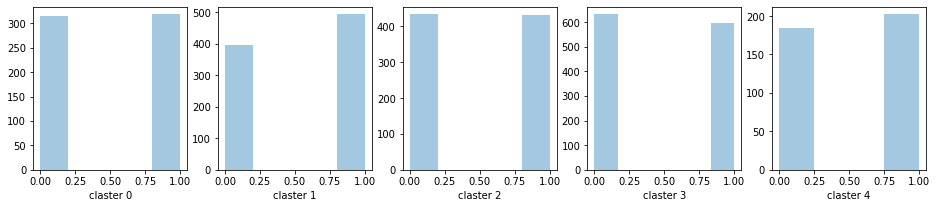

'Near_Location'

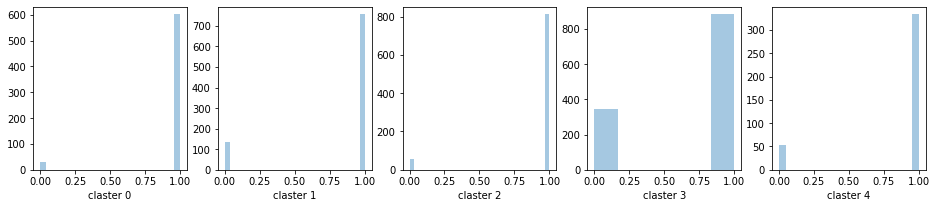

'Partner'

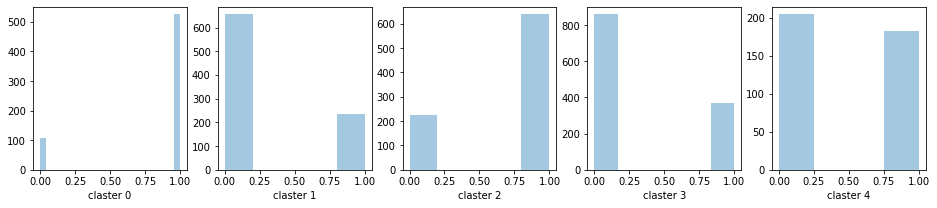

'Promo_friends'

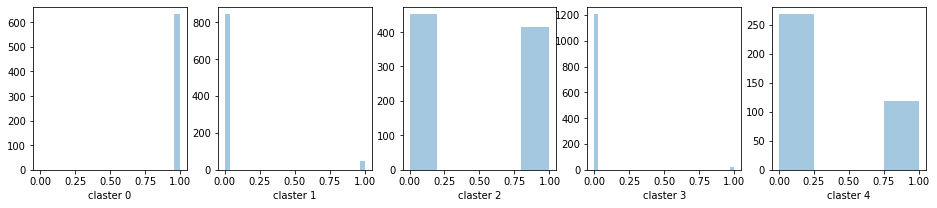

'Phone'

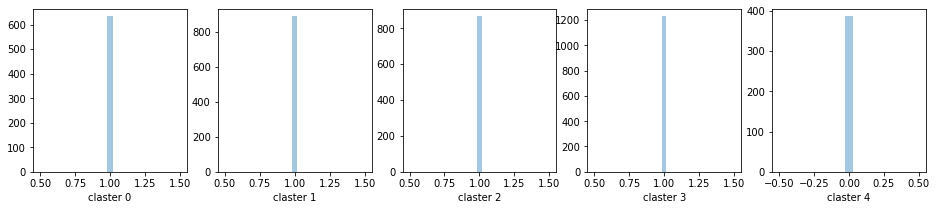

'Contract_period'

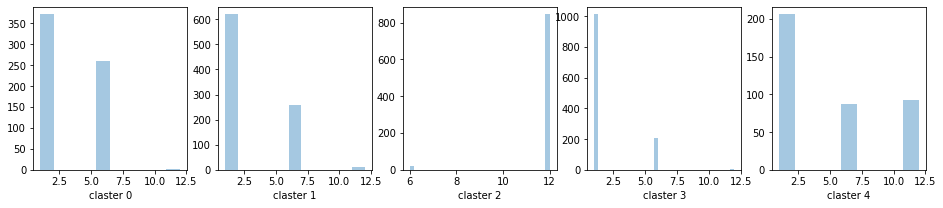

'Group_visits'

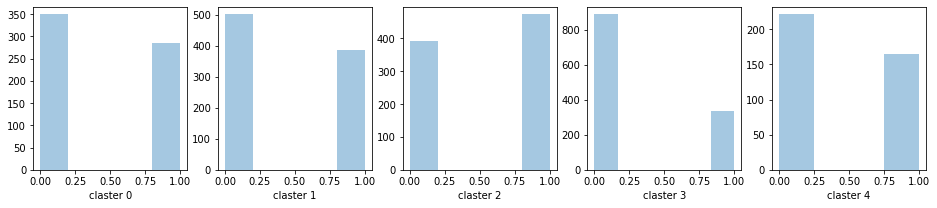

'Age'

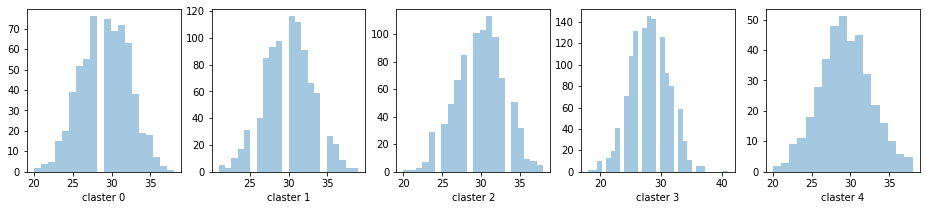

'Avg_additional_charges_total'

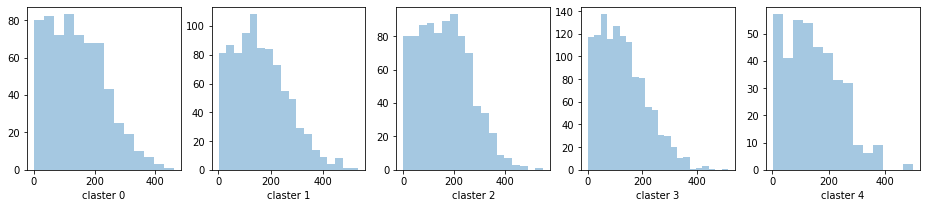

'Month_to_end_contract'

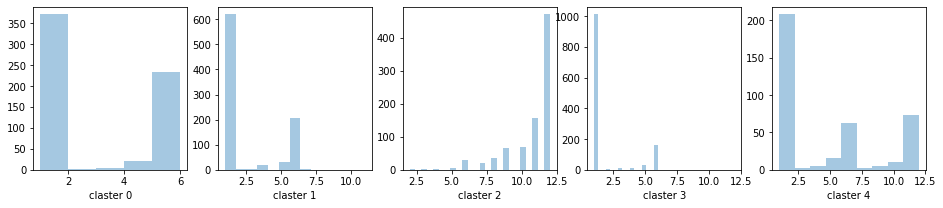

'Lifetime'

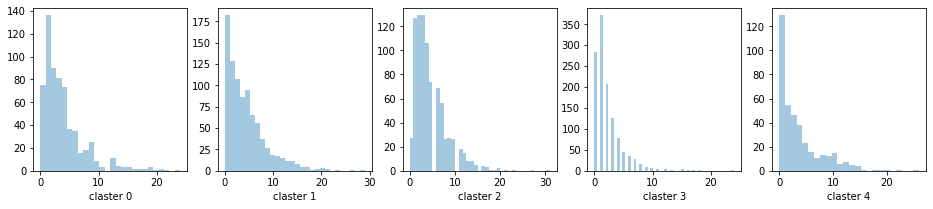

'Avg_class_frequency_total'

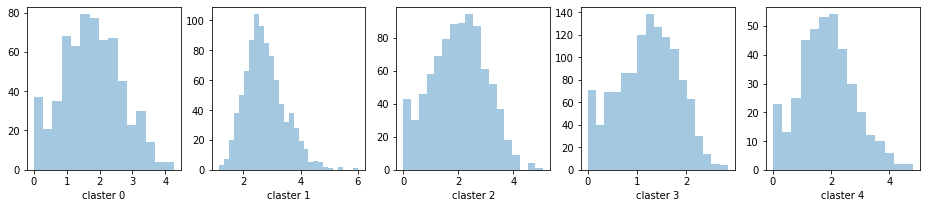

'Avg_class_frequency_current_month'

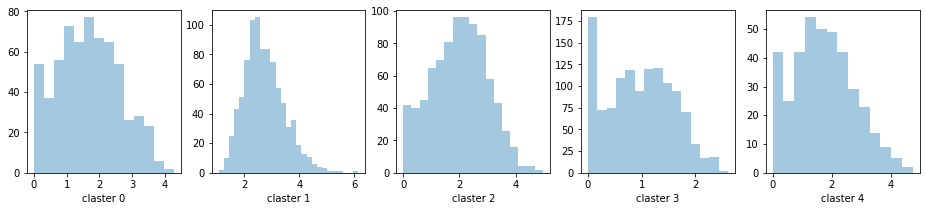

'Churn'

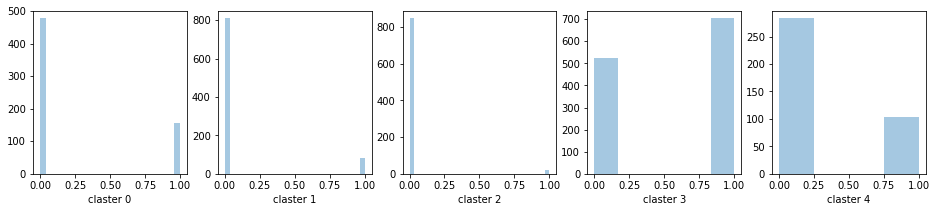

'claster'

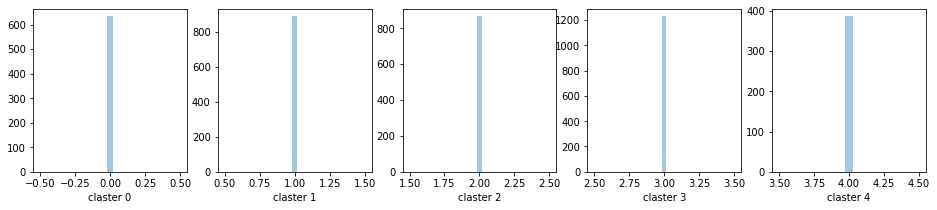

In [17]:
#построим гистограммы по признакам с разбивкой на кластеры

#пройдемся циклом по всем колонкам
for col in df.columns:
    display(col)
    
    #на каждом графике будем выводить в строку один признак для всех 5ти кластеров
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(16,3))
    axes = [ax0, ax1, ax2, ax3, ax4]
    
    #последовательно проходимся по каждому кластеру
    for cl in range(5):
        sns.distplot(df.query('claster == @cl')[col], kde=False, ax=axes[cl])
        axes[cl].set_xlabel('claster ' + str(cl))
    
    plt.show()

#### Основные признаки кластеров подтверждаются и диаграммами
Дополнительно:
- Во всех кластерах примерно одинаковое кол-во мужчин и женщин
- В кластере 3 практически все пришли сами (без промо друзей или партнерской программы)
- Средний возраст во всех кластерах 28-30 лет
- Выручка от сопутствующих услуг ('Avg_additional_charges_total') чуть больше у 1го и 2го кластеров, чем у остальных. Но в этих кластерах и lifetime чуть выше
- Больше всего клиентов в кластере "3", самый маленький кластер "4"

#### Самые надежные кластеры "2" и "1", отток 2% и 9%, соответственно. Ненадежный кластер  - "3" (57%)

# 5. Выводы и рекомендации <a class="anchor" id="5"></a>

Анализ проводился на 4000 клиентах клуба.
- Мужчин и женщин примерно поровну.
- Большинство клиентов в клубе всего 3 месяца. Скорее всего в основном приходят "подкачаться" к сезону
- Посещают клуб менее 2х раз в неделю
- Отток 27%

Основые выводы:
- Клиенты реже уходят, если они пришли по рекомендациям друзей и по партнерской программе. Это дает меньше повода "забить" на занятия. Важна социальная составляющая.Это также подтверждает тот факт, что 46% этих клиентов посещают и групповые занятия
- Маркером, что клиент скоро "отвалится", можно считать среднее кол-во посещений зала. Если клиент начал ходить меньше 1,5 раз в неделю, то скоро он уйдет совсем. Те кто ходят 2 раза в неделю, остаются дольше клиентом клуба
-  Характер посещений клуба одинаковый - если клиенты начали ходить редко, то и продолжают ходить редко
- На основе алгоритма логарифмическая регрессия построена модель, которая предсказывает отток клиента с точностью 86% и полнотой 83%


Рекомендации:
- Стараться продавать более длительные абонементы (6 мес и более). Желательно на 12 месяцев
- Делавать баллы за акцию приведи друга. Причем чем более длительный абонемент возьмет друг, тем больше баллов тому, кто его привел. Баллы можно использовать для покупок доп.услуг клуба
- Устраивать больше групповых занятий и следить за их качеством, чтобы люди могли знакомиться на занятиях и узнавать больше друг о друге